In [1]:
import pathlib
import sys
PATH = pathlib.Path().absolute().resolve()

%matplotlib inline
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tk
import matplotlib.colors as clr
import seaborn as sns
import skimage.measure as msr

sns.set(style="whitegrid", font_scale=1.4)
COLORS = sns.color_palette()

In [2]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
import json
import zstandard
from scipy.ndimage import gaussian_filter
from random import choice

In [4]:
import uuid
from IPython.display import display_javascript, display_html, display
import json
import IPython.core.display

class RenderJSON(object):
    def __init__(self, json_data):
        if isinstance(json_data, dict):
            self.json_str = json.dumps(json_data)
        else:
            self.json_str = json_data
        self.uuid = str(uuid.uuid4())

    def _ipython_display_(self):
        display_html('<div id="{}" style="height: 600px; width:100%;"></div>'.format(self.uuid), raw=True)
        display_javascript("""
        require(["https://rawgit.com/caldwell/renderjson/master/renderjson.js"], function() {
        document.getElementById('%s').appendChild(renderjson(%s))
        });
        """ % (self.uuid, self.json_str), raw=True)
        
def _html_repr_helper(contents, index, is_horz):
    dims_left = contents.ndim - len(index)
    if dims_left == 0:
        s = contents[index]
    else:
        s = '<span class="numpy-array-comma">,</span>'.join(
            _html_repr_helper(contents, index + (i,), is_horz) for i in range(contents.shape[len(index)])
        )
        s = ('<span class="numpy-array-bracket numpy-array-bracket-open">[</span>'
            '{}'
            '<span class="numpy-array-bracket numpy-array-bracket-close">]</span>'.format(s))
        
    # apply some classes for styling
    classes = []
    classes.append('numpy-array-slice')
    classes.append('numpy-array-ndim-{}'.format(len(index)))
    classes.append('numpy-array-ndim-m{}'.format(dims_left))
    if is_horz(contents, len(index)):
        classes.append('numpy-array-horizontal')
    else:
        classes.append('numpy-array-vertical')
    
    hover_text = '[{}]'.format(','.join('{}'.format(i) for i in (index + (':',) * dims_left)))

    return "<span class='{}' title='{}'>{}</span>".format(
        ' '.join(classes), hover_text, s,
    )

basic_css = """
    .numpy-array {
        display: inline-block;
    }
    .numpy-array .numpy-array-slice {
        border: 1px solid #cfcfcf;
        border-radius: 4px;
        margin: 1px;
        padding: 1px;
        display: flex;
        flex: 1;
        text-align: right;
        position: relative;
    }
    .numpy-array .numpy-array-slice:hover {
        border: 1px solid #66BB6A;
    }
    .numpy-array .numpy-array-slice.numpy-array-vertical {
        flex-direction: column;
    }
    .numpy-array .numpy-array-slice.numpy-array-horizontal {
        flex-direction: row;
    }
    .numpy-array .numpy-array-ndim-m0 {
        padding: 5px;
    }
    
    /* Hide the comma and square bracket characters which exist to help with copy paste */
    .numpy-array .numpy-array-bracket {
        font-size: 0;
        position: absolute;
    }
    .numpy-array span .numpy-array-comma {
        font-size: 0;
        height: 0;
    }
"""

show_brackets_css = """
    .numpy-array.show-brackets .numpy-array-slice {
        border-radius: 0;
    }
    .numpy-array.show-brackets .numpy-array-bracket {
        border: 1px solid black; 
        border-radius: 0;  /* looks better without... */
    }
    .numpy-array.show-brackets .numpy-array-horizontal > .numpy-array-bracket-open {
        top: -1px;
        bottom: -1px;
        left: -1px;
        width: 10px;
        border-right: none;
        border-top-right-radius: 0;
        border-bottom-right-radius: 0;
    }
    .numpy-array.show-brackets .numpy-array-horizontal > .numpy-array-bracket-close {
        top: -1px;
        bottom: -1px;
        right: -1px;
        width: 10px;
        border-left: none;
        border-top-left-radius: 0;
        border-bottom-left-radius: 0;
    }
    .numpy-array.show-brackets .numpy-array-vertical > .numpy-array-bracket-open {
        top: -1px;
        right: -1px;
        left: -1px;
        height: 10px;
        border-bottom: none;
        border-bottom-right-radius: 0;
        border-bottom-left-radius: 0;
    }
    .numpy-array.show-brackets .numpy-array-vertical > .numpy-array-bracket-close {
        left: -1px;
        bottom: -1px;
        right: -1px;
        height: 10px;
        border-top: none;
        border-top-right-radius: 0;
        border-top-left-radius: 0;
    }
"""

def make_pretty(self, show_brackets=False, is_horz=lambda arr, ax: ax == arr.ndim - 1):

    classes = ['numpy-array']
    css = basic_css
    if show_brackets:
        classes += ['show-brackets']
        css += show_brackets_css
    return IPython.core.display.HTML(
        """<style>{}</style><div class='{}'>{}</div>""".format(
            css,
            ' '.join(classes),
            _html_repr_helper(self, (), is_horz))
    )

In [5]:
def ax_style(ax, xticks=None, yticks=None, grid_color=None):
    grid_kwargs = {}
    if grid_color:
        grid_kwargs["color"] = grid_color
    if grid_kwargs:
        ax.grid(**grid_kwargs)
    ax.grid(which='minor', axis='x', dashes=(5, 5), linewidth=.5, **grid_kwargs)
    ax.grid(which='minor', axis='y', dashes=(5, 5), linewidth=.5, **grid_kwargs)
    ax.legend()
    ax.minorticks_on()
    if xticks:
        if isinstance(xticks, int) or isinstance(xticks, float):
            ax.xaxis.set_ticks(np.arange(0, xticks + 1, 1.0))
        elif len(xticks) == 2:
            ax.xaxis.set_ticks(np.arange(0, xticks[0] + 1, xticks[1]))
        elif len(xticks) == 3:
            ax.xaxis.set_ticks(np.arange(xticks[0], xticks[1] + 1, xticks[2]))
    if yticks:
        if isinstance(yticks, int) or isinstance(yticks, float):
            ax.yaxis.set_ticks(np.arange(0, yticks + 1, 1.0))
        elif len(yticks) == 2:
            ax.yaxis.set_ticks(np.arange(0, yticks[0] + 1, yticks[1]))
        elif len(yticks) == 3:
            ax.yaxis.set_ticks(np.arange(yticks[0], yticks[1] + 1, yticks[2]))
            
    return ax


In [99]:
def extend_grid(grid, as_view=False):
    if as_view:
        grid = grid.view()
    h, w = grid.shape
    extended_grid = np.zeros((w * 2, h * 2), dtype=grid.dtype)
    w2 = w // 2
    h2 = h // 2
    extended_grid[0:h2,     0   :w2  ] = grid[h2:h, w2:w ]
    extended_grid[0:h2,     w2  :w+w2] = grid[h2:h, 0 :w ]
    extended_grid[0:h2,     w+w2:w+w ] = grid[h2:h, 0 :w2]
    
    extended_grid[h2:h+h2,  0   :w2  ] = grid[0:h,  w2:w ]
    extended_grid[h2:h+h2,  w2  :w+w2] = grid[0:h,  0 :w ]
    extended_grid[h2:h+h2,  w+w2:w+w ] = grid[0:h,  0 :w2]
    
    extended_grid[h+h2:h+h, 0   :w2  ] = grid[0:h2, w2:w ]
    extended_grid[h+h2:h+h, w2  :w+w2] = grid[0:h2, 0 :w ]
    extended_grid[h+h2:h+h, w+w2:w+w ] = grid[0:h2, 0 :w2]
    return extended_grid

In [7]:
@tk.FuncFormatter
def pseudo_formatter(x, pos):
    return str(x) if 0 <= x <= w else f"[{(x % w) if x > 0 else w - abs(x)}]"

In [9]:
mask_cmap = clr.ListedColormap([(0,0,0,0), (1,1,1,.5)])
mask_cmap.set_over('0.25')
mask_cmap.set_under('0.75')

def plot_grid(grid, ax, mask=None):
    h_loc, w_loc = grid.shape
    top = (h - h_loc) // 2
    bottom = h_loc // 2 + h // 2
    left = (w - w_loc) // 2
    right = w_loc // 2 + w // 2
    ax.imshow(grid, interpolation=None, vmax=1000, extent=(left, right, bottom, top), zorder=-2)
    if mask is not None:
        ax.imshow(mask, interpolation=None, extent=(left, right, bottom, top), zorder=-1, cmap=mask_cmap)
    ax.axhline(0, color="white", zorder=10)
    ax.axhline(h, color="white", zorder=10)
    ax.axvline(0, color="white", zorder=10)
    ax.axvline(w, color="white", zorder=10)
    ax_style(
        ax,
        xticks=(left, right, 4),
        yticks=(top, bottom, 4),
        grid_color="#666666"
    )
    ax.set_xlim(left, right)
    ax.set_ylim(bottom, top)
    ax.xaxis.set_major_formatter(pseudo_formatter)
    ax.yaxis.set_major_formatter(pseudo_formatter)
    ax.xaxis.tick_top()

In [10]:
from skimage import draw

def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

In [136]:
dctx = zstandard.ZstdDecompressor()
replay = list(filter(
    lambda p: p.stat().st_size > 0,
    (PATH / "replays").glob("*.hlt")
))
replay = choice(replay)
with replay.open("rb") as f:
    replay_json = json.loads(dctx.decompress(f.read()))

In [137]:
halite_map = [[i['energy'] for i in row] for row in replay_json["production_map"]["grid"]]
grid = np.array(halite_map, dtype=float)
w, h = replay_json["production_map"]["width"], replay_json["production_map"]["height"]

In [138]:
shipyard = np.array([24, 24], dtype=float)
a, b = shipyard
r = 10
y,x = np.ogrid[-a:h-a, -b:w-b]
mask = x*x + y*y <= r*r
ex_mask = extend_grid(mask)

In [139]:
grid[mask] /= 10
extended_grid = extend_grid(grid)
gb_grid = gaussian_filter(grid, sigma=2, truncate=2.0, mode='wrap')
d = 2
extended_grid[:d, 0:2*w] = 0
extended_grid[-d:, 0:2*w] = 0
extended_grid[0:2*h, :d] = 0
extended_grid[0:2*h, -d:] = 0
gb_ex_grid = gaussian_filter(extended_grid, sigma=2, truncate=2.0, mode='wrap')

In [152]:
contours = msr.find_contours(gb_ex_grid, gb_grid.max() * .4, fully_connected="high")
contours_2 = [c - h // 2 for c in contours]
masks = [poly2mask(c[:, 0], c[:, 1], gb_ex_grid.shape)[h//2:3 * h//2, w//2:3 * w//2] for c in contours]
points = {tuple(float(int(x)) for x in p) for c in contours_2 for p in c if all(0 <= x < h for x in p)}
points = [list(point) for point in points]
points = np.array(points, dtype=np.int)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


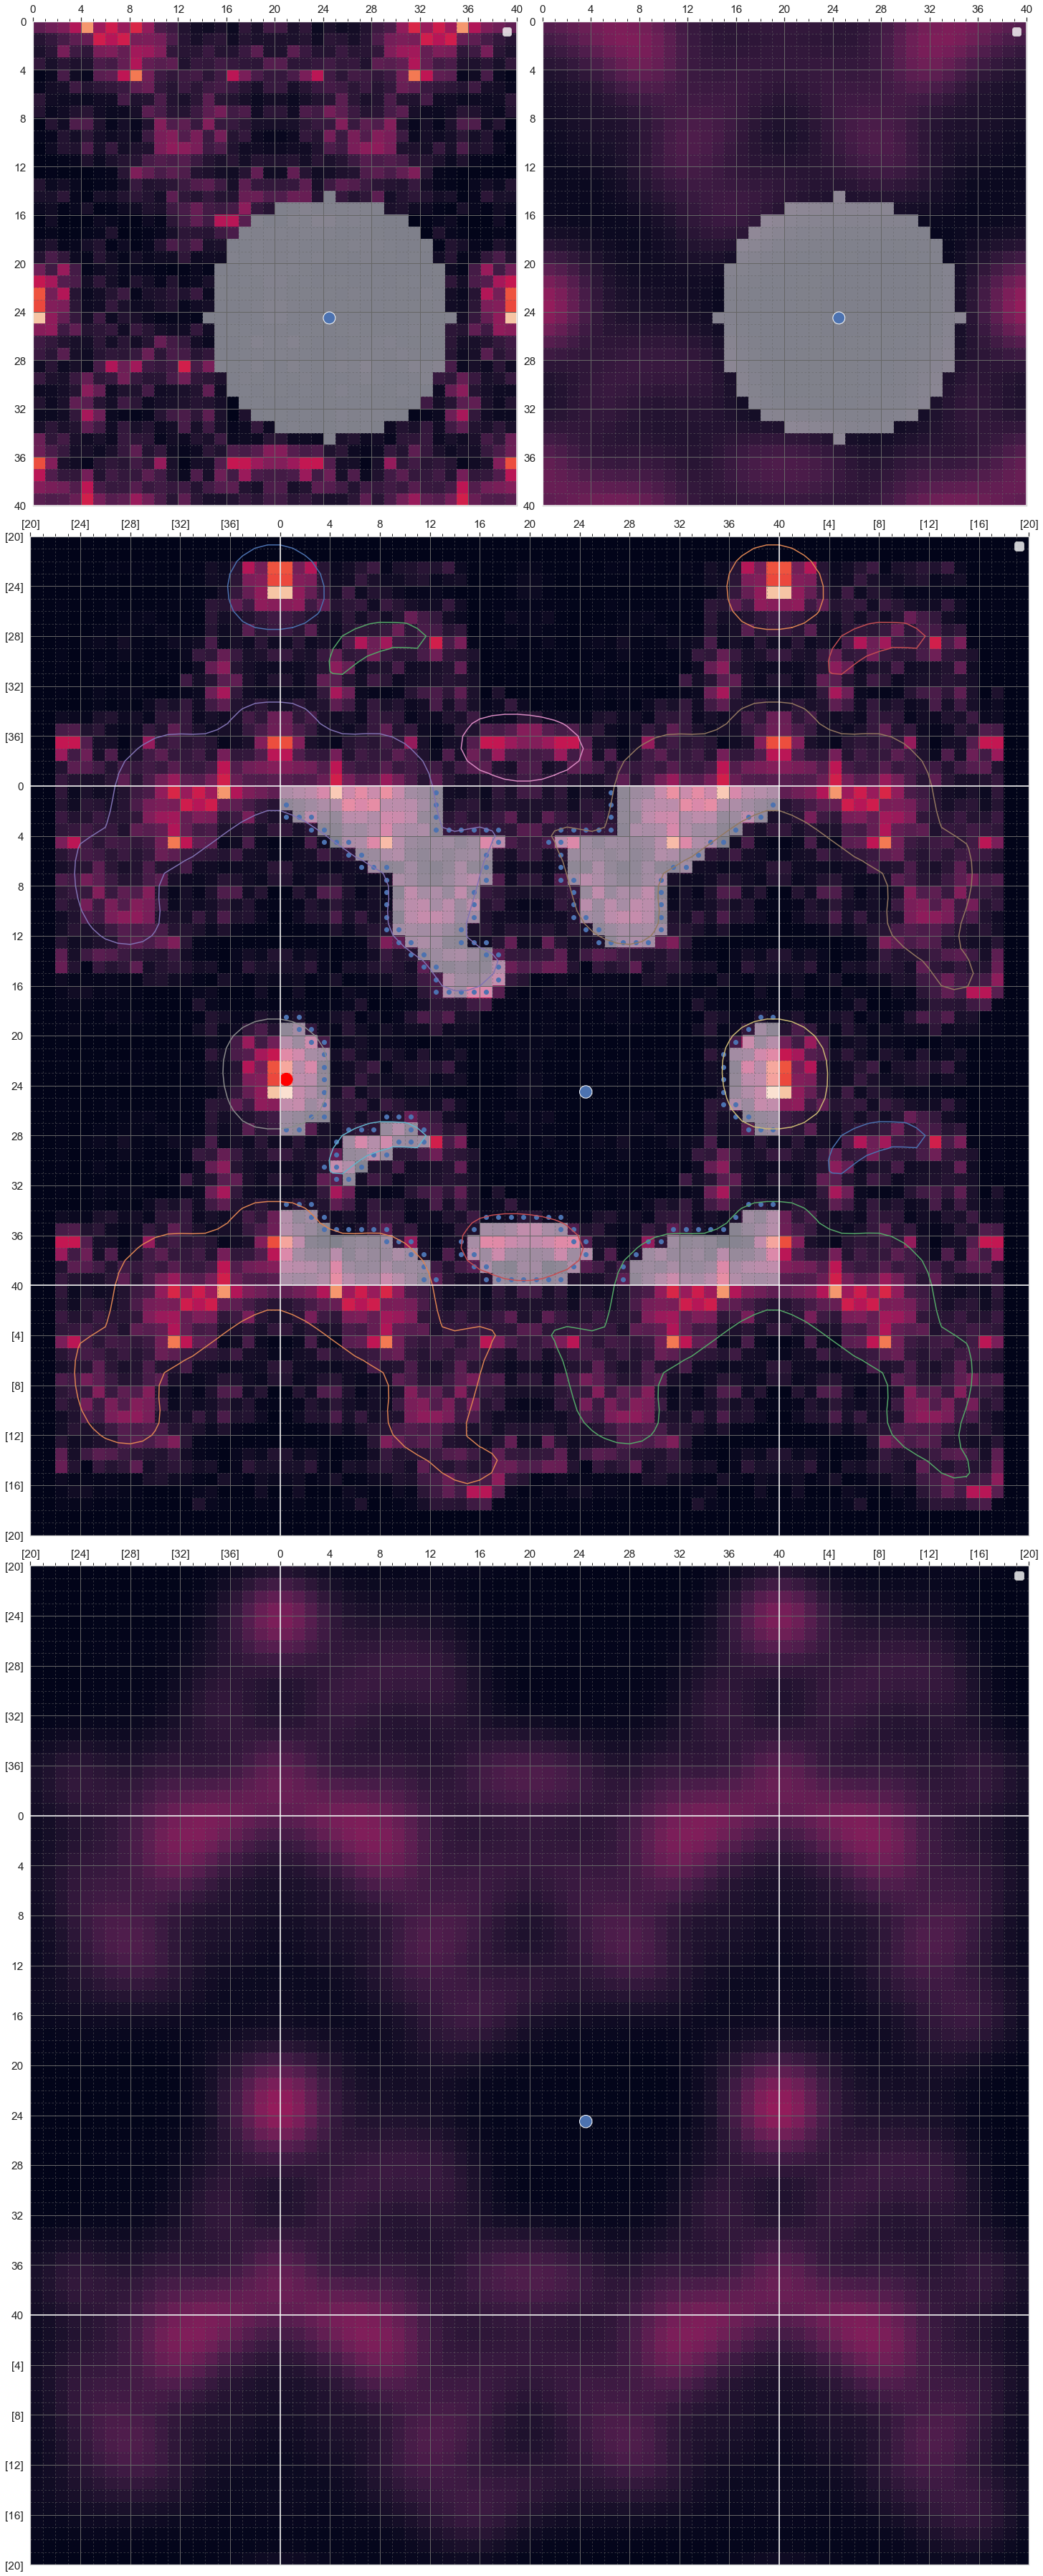

In [154]:
grids = (
    (grid, gb_grid),
    extended_grid,
    gb_ex_grid,
)
rows = 0
span_rows = 0
cols = 2
for g in grids:
    if isinstance(g, tuple):
        rows += 1
        cols = max(cols, len(g))
    else:
        span_rows += 1
rows += span_rows * cols
fig = plt.figure(figsize=(10 * cols, 10 * rows))
i = 0
axes = {}
for row, g in enumerate(grids):
    if isinstance(g, tuple):
        for j, sub_g in enumerate(g):
            ax = plt.subplot2grid((rows, cols), (i, j))
            axes[(row, j)] = ax
            plot_grid(sub_g, ax, mask)
            ax.add_patch(plt.Circle(shipyard + .5, .5))
        i += 1
    else:
        ax = plt.subplot2grid((rows, cols), (i, 0), colspan=cols, rowspan=cols)
        axes[(row, 0)] = ax
        plot_grid(g, ax)
        ax.add_patch(plt.Circle(shipyard + .5, .5))
        i += cols


ax = axes[(1, 0)]
ax.add_patch(plt.Circle(
    np.array(np.unravel_index(gb_grid.argmax(), gb_grid.shape))[::-1] + .5,
    .5,
    color='red'
))
for n, (c, m) in enumerate(zip(contours, masks)):
    ax.plot(c[:, 1] - h//2, c[:, 0] - w//2)
    ax.imshow(m, interpolation=None, extent=(0, w, h, 0), zorder=-1, cmap=mask_cmap)
ax.scatter(points[:, 1] + .5, points[:, 0] + .5)
    
fig.tight_layout()
plt.show()

In [155]:
grid[range(10), range(10)]

array([250., 139., 301.,  82.,  26., 120.,  49.,  38.,  26., 159.])